In [1]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv(r'districts.csv',parse_dates = ['Date'])

In [3]:
# State code paired up with their name
state_change=[['AN', 'Andaman and Nicobar Islands'], ['AP', 'Andhra Pradesh'], ['AR', 'Arunachal Pradesh'], 
              ['AS', 'Assam'], ['BH', 'Bihar'], ['CH', 'Chandigarh'], ['CT', 'Chhattisgarh'], 
              ['DN', 'Dadra and Nagar Haveli and Daman and Diu'], ['DL', 'Delhi'], ['GA', 'Goa'], 
              ['GJ', 'Gujarat'], ['HR', 'Haryana'], ['HP', 'Himachal Pradesh'], ['JK', 'Jammu and Kashmir'], 
              ['JH', 'Jharkhand'], ['KA', 'Karnataka'], ['KL', 'Kerala'], ['LA', 'Ladakh'], ['LD', 'Lakshadweep'], 
              ['MP', 'Madhya Pradesh'], ['MH', 'Maharashtra'], ['MN', 'Manipur'], ['ME', 'Meghalaya'], ['MI', 'Mizoram'],
              ['NL', 'Nagaland'], ['OR', 'Odisha'], ['PY', 'Puducherry'], ['PB', 'Punjab'], ['RJ', 'Rajasthan'], 
              ['SK', 'Sikkim'], ['TN', 'Tamil Nadu'], ['TS', 'Telangana'], ['TR', 'Tripura'], ['UP', 'Uttar Pradesh'], 
              ['UT', 'Uttarakhand'], ['WB', 'West Bengal']]
state_change_rev = [['Andaman and Nicobar Islands', 'AN'],[ 'Andhra Pradesh',  'AP'],[ 'Arunachal Pradesh', 'AR'],[ 'Assam',  'AS'],[ 'Bihar',  'BH'],
 [ 'Chandigarh' ,'CH'],[ 'Chhattisgarh' , 'CT'], ['Dadra and Nagar Haveli and Daman and Diu',  'DN'],
  ['Delhi',  'DL'], ['Goa',  'GA'], ['Gujarat',  'GJ'], ['Haryana',  'HR'],[ 'Himachal Pradesh',  'HP'],
  ['Jammu and Kashmir',  'JK'],[ 'Jharkhand',  'JH'],[ 'Karnataka',  'KA'],[ 'Kerala',  'KL'],['Ladakh','LA'],
              [ 'Lakshadweep', 'LD'],
 [ 'Madhya Pradesh',  'MP'],[ 'Maharashtra',  'MH'],['Manipur',  'MN'],[ 'Meghalaya','ME'],[ 'Mizoram',  'MI'],
 ['Nagaland',  'NL'],[ 'Odisha',  'OR'],[ 'Puducherry',  'PY'],[ 'Punjab',  'PB'],['Rajasthan',  'RJ'],
 ['Sikkim',  'SK'],['Tamil Nadu', 'TN'],['Telangana',  'TS'],['Tripura','TR'],['Uttar Pradesh',  'UP'],
 ['Uttarakhand',  'UT'],['West Bengal',  'WB']]

In [4]:
# Dropping rows with unnecessary dates from dataframe
drop_indices = df[df['Date'] >= '2021-08-15'].index
df.drop(drop_indices, inplace = True)
df.shape

(307246, 8)

In [5]:
# Forming state code and district id from state and district columns
df['state_code'] = [j[1] for i in df['State'] for j in state_change_rev if i==j[0] ]
df['district_id'] = df['state_code']+'_'+df['District'] 
df = df.sort_values(by=['district_id','Date'], ascending=True)
df.drop(['Other','Tested'], axis='columns', inplace=True)

In [6]:
df.columns

Index(['Date', 'State', 'District', 'Confirmed', 'Recovered', 'Deceased',
       'state_code', 'district_id'],
      dtype='object')

In [7]:
s_list = list(df['district_id'].unique()) # Unique districts from available data
s_list.sort()

In [8]:
df['active'] = df['Confirmed'] - df['Recovered'] - df['Deceased'] # Calculating active cases 

In [9]:
# Grouping rows corresponding to one district into one dataframe and then storing all such into one list (master_list)
master_list = []
for i in s_list:
    temp_df  = pd.DataFrame(columns = ['Date','district_id','active'])
    temp_df = df[df['district_id'] == i]
    master_list.append([i,temp_df])

In [10]:
# Adding only one extra date 15th March 2020 with zeros into each dataframe
sd = np.datetime64('2020-03-15')
for i in master_list:
    i[1] =  i[1].append({'Date':sd,'district_id':i[0],'active':0},ignore_index=True)
    i[1] = i[1].sort_values(by=['Date'], ascending=True)

In [11]:
# Time intensive loop
# Core logic for calculation here is: no of cases in a week is = saturday of present week minus previous week's saturday
# Core logic for calculation here is: no of cases in next overlapped week is = wednesday of next week minus this week's wednesday
output_list_week = []
main_df = pd.DataFrame(columns = ['district_id','Week_id','active'])
for i in master_list:
    week = 1
    temp_df = pd.DataFrame(columns = ['district_id','Week_id','active'])
    start_date = np.datetime64(i[1][0:1]['Date'].to_string(index = False))
    end_date = np.datetime64(i[1][-1:]['Date'].to_string(index = False))
    date_list = list(i[1]['Date'])
    active_list = list(i[1]['active'])
    while (start_date <= end_date):
        it2 = start_date + np.timedelta64(6,'D')
        it1 = start_date - np.timedelta64(1,'D')
        ind_it1 = 0
        ind_it2 = 0
        for j in range(0,len(date_list)):
            if date_list[j] == it1:
                ind_it1 = j
            if date_list[j] == it2:
                ind_it2 = j
        temp_df = temp_df.append(pd.DataFrame({"district_id": i[0],"Week_id":week,"active":active_list[ind_it2]}, index=[0]))
        start_date = start_date + np.timedelta64(3+(week%2),'D') # Logic to add required days to get next overlapped week's start date
        week = week + 1
    output_list_week.append([i[0],temp_df])
    main_df = main_df.append(temp_df)

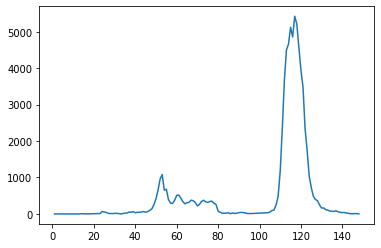

In [12]:
# Illustration for one district across all weeks
x = list(main_df[main_df['district_id']=='CT_Kabeerdham']['Week_id'])
y = list(main_df[main_df['district_id']=='CT_Kabeerdham']['active'])
plt.plot(x,y)
plt.show()

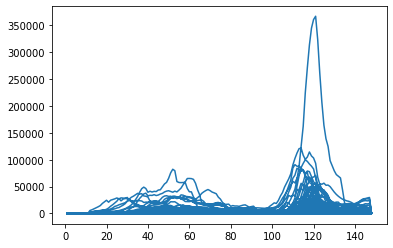

In [13]:
# Illustration for all districts across all weeks
x = list(main_df['Week_id'])
y = list(main_df['active'])
plt.plot(x,y)
plt.show()

In [14]:
# Function that returns the peak week id's
# Divides dataframe into two halves for calculating peaks
def utility(temp_df,col_name,num,wm_id):
    temp_active = list(temp_df[col_name])
    m1 = max(temp_active[:num],default=0)
    m2 = max(temp_active[num:],default=0)
    temp_df1 = list(temp_df[temp_df[col_name]==m1][wm_id])
    if m2!=0:
        temp_df2 = list(temp_df[temp_df[col_name]==m2][wm_id])
    else:
        temp_df2 = [len(temp_df)]
    return temp_df1,temp_df2

In [15]:
peak_week_df = pd.DataFrame(columns = ['district_id','Week_id','Week_id2'])
for i in output_list_week:
    temp_df = i[1]
    temp_df1,temp_df2 = utility(temp_df,"active",81,"Week_id") # Dividing 81 st overlapping week as separation boundary for calculating peaks for first wave and second wave
    peak_week_df = peak_week_df.append(pd.DataFrame({"district_id": i[0],"Week_id":temp_df2[0],"Week_id2":temp_df1[0]},index = [0]))

In [16]:
peak_week_df.head()

,district_id,Week_id,Week_id2
0,AN_Unknown,123,43
0,AP_Anantapur,121,39
0,AP_Chittoor,123,45
0,AP_East Godavari,124,48
0,AP_Foreign Evacuees,148,30


In [17]:
# Time intensive loop
# Manually mentioned the dates that needs to be substracted to calculate peaks for months
month_main_df = pd.DataFrame(columns = ['district_id','Month_id','active'])
output_list_month = []
month_list = [['2020-03-14','2020-04-14'],['2020-04-14','2020-05-14'],['2020-05-14','2020-06-14'],
             ['2020-06-14','2020-07-14'],['2020-07-14','2020-08-14'],['2020-08-14','2020-09-14'],
             ['2020-09-14','2020-10-14'],['2020-10-14','2020-11-14'],['2020-11-14','2020-12-14'],
             ['2020-12-14','2021-01-14'],['2021-01-14','2021-02-14'],['2021-02-14','2021-03-14'],
             ['2021-03-14','2021-04-14'],['2021-04-14','2021-05-14'],['2021-05-14','2021-06-14'],
             ['2021-06-14','2021-07-14'],['2021-07-14','2021-08-14'],['2021-08-14','2021-09-14']]
for i in master_list:
    month = 0
    temp_df = pd.DataFrame(columns = ['district_id','Month_id','active'])
    start_date = np.datetime64('2020-03-14')
    end_date = np.datetime64(i[1][-1:]['Date'].to_string(index = False))
    date_list = list(i[1]['Date'])
    active_list = list(i[1]['active'])
    while (start_date <= end_date) and (month<17):
        it2 = np.datetime64(month_list[month][1])
        it1 = np.datetime64(month_list[month][0])
        ind_it1 = 0
        ind_it2 = 0
        for j in range(0,len(date_list)):
            if date_list[j] == it1:
                ind_it1 = j
            if date_list[j] == it2:
                ind_it2 = j
        temp_df = temp_df.append(pd.DataFrame({"district_id": i[0],"Month_id":month+1,"active":active_list[ind_it2]}, index=[0]))
        month = month + 1
    output_list_month.append([i[0],temp_df])
    month_main_df = month_main_df.append(temp_df)

In [18]:
peak_month_df = pd.DataFrame(columns = ['district_id','Month_id','Month_id2'])
for i in output_list_month:
    temp_df = i[1]
    temp_df1,temp_df2 = utility(temp_df,"active",9,"Month_id")
    peak_month_df = peak_month_df.append(pd.DataFrame({"district_id": i[0],"Month_id":temp_df2[0],"Month_id2":temp_df1[0]},index = [0]))

In [19]:
peak_month_df.head()

,district_id,Month_id,Month_id2
0,AN_Unknown,14,5
0,AP_Anantapur,14,5
0,AP_Chittoor,14,5
0,AP_East Godavari,14,5
0,AP_Foreign Evacuees,17,3


In [20]:
s_list_state = list(df['State'].unique()) # List of all states
s_list_state.sort()

In [21]:
# Merging same state districts into one state then merging them based on week id's

In [22]:
main_df_week_state = main_df
main_df_week_state['state'] = [i[0:2] for i in main_df_week_state['district_id']]
main_df_week_state['state'] = [j[1] for i in main_df_week_state['state'] for j in state_change if i==j[0] ]
main_df_week_state = main_df_week_state.sort_values(by=['state'], ascending=True)
main_df_week_state = main_df_week_state[['state','Week_id','active']]
main_df_week_state = main_df_week_state.groupby(['state','Week_id'],as_index=False).agg({'active': 'sum'})

In [23]:
peak_state_week_df = pd.DataFrame(columns = ['state','Week_id','Week_id2'])
for i in s_list_state:
    temp_df = main_df_week_state
    temp_df = temp_df[temp_df['state']==i]
    temp_df1,temp_df2 = utility(temp_df,"active",81,"Week_id") # Dividing 81 st overlapping week as separation boundary for calculating peaks for first wave and second wave
    peak_state_week_df = peak_state_week_df.append(pd.DataFrame({"state": i,"Week_id":temp_df2[0],"Week_id2":temp_df1[0]},index = [0]))

In [24]:
peak_state_week_df.head()

,state,Week_id,Week_id2
0,Andaman and Nicobar Islands,123,43
0,Andhra Pradesh,123,48
0,Arunachal Pradesh,141,60
0,Assam,125,56
0,Bihar,118,43


In [25]:
# Merging same state districts into one state then merging them based on month id's

In [26]:
pmsdf = month_main_df
pmsdf['state'] = [i[0:2] for i in pmsdf['district_id']]
pmsdf['state'] = [j[1] for i in pmsdf['state'] for j in state_change if i==j[0] ]
pmsdf = pmsdf.sort_values(by=['state'], ascending=True)
pmsdf = pmsdf[['state','Month_id','active']]
pmsdf = pmsdf.groupby(['state','Month_id'],as_index=False).agg({'active': 'sum'})

In [27]:
pmsdf.head()

,state,Month_id,active
0,Andaman and Nicobar Islands,1,0
1,Andaman and Nicobar Islands,2,0
2,Andaman and Nicobar Islands,3,7
3,Andaman and Nicobar Islands,4,42
4,Andaman and Nicobar Islands,5,1130


In [28]:
peak_state_month_df = pd.DataFrame(columns = ['state','Month_id','Month_id2'])
for i in s_list_state:
    temp_df = pmsdf
    temp_df = temp_df[temp_df['state']==i]
    temp_df1,temp_df2 = utility(temp_df,"active",9,"Month_id") # Dividing 9 th month as separation boundary for calculating peaks for first wave and second wave
    peak_state_month_df = peak_state_month_df.append(pd.DataFrame({"state": i,"Month_id":temp_df2[0],"Month_id2":temp_df1[0]},index = [0]))

In [29]:
peak_state_month_df.head()

,state,Month_id,Month_id2
0,Andaman and Nicobar Islands,14,5
0,Andhra Pradesh,14,6
0,Arunachal Pradesh,16,7
0,Assam,14,7
0,Bihar,14,5


In [30]:
# Merging district information into one dataframe

In [31]:
peak_district = peak_week_df
peak_district['wave1-weekid'] = peak_district['Week_id2']
peak_district['wave2-weekid'] = peak_district['Week_id']

In [32]:
peak_district = peak_district[['district_id','wave1-weekid','wave2-weekid']]

In [33]:
peak_district['wave1-monthid'] = peak_month_df['Month_id2']

C:\Users\siddh\AppData\Local\Temp/ipykernel_3900/1884361101.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peak_district['wave1-monthid'] = peak_month_df['Month_id2']


In [34]:
peak_district['wave2-monthid'] = peak_month_df['Month_id']

In [35]:
peak_district

,district_id,wave1-weekid,wave2-weekid,wave1-monthid,wave2-monthid
0,AN_Unknown,43,123,5,14
0,AP_Anantapur,39,121,5,14
0,AP_Chittoor,45,123,5,14
0,AP_East Godavari,48,124,5,14
0,AP_Foreign Evacuees,30,148,3,17
...,...,...,...,...,...
0,WB_Purba Medinipur,67,123,6,14
0,WB_Purulia,53,116,7,14
0,WB_South 24 Parganas,65,123,5,14
0,WB_Unknown,13,21,1,17


In [36]:
# Merging state information into one dataframe

In [37]:
peak_state = peak_state_week_df
peak_state['wave1-weekid'] = peak_state['Week_id2']
peak_state['wave2-weekid'] = peak_state['Week_id']

In [38]:
peak_state = peak_state[['state','wave1-weekid','wave2-weekid']]

In [39]:
peak_state['wave1-monthid'] = peak_state_month_df['Month_id2']

C:\Users\siddh\AppData\Local\Temp/ipykernel_3900/2041072297.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peak_state['wave1-monthid'] = peak_state_month_df['Month_id2']


In [40]:
peak_state['wave2-monthid'] = peak_state_month_df['Month_id']

In [41]:
peak_state

,state,wave1-weekid,wave2-weekid,wave1-monthid,wave2-monthid
0,Andaman and Nicobar Islands,43,123,5,14
0,Andhra Pradesh,48,123,6,14
0,Arunachal Pradesh,60,141,7,16
0,Assam,56,125,7,14
0,Bihar,43,118,5,14
0,Chandigarh,52,120,6,14
0,Chhattisgarh,53,119,6,13
0,Dadra and Nagar Haveli and Daman and Diu,43,116,5,14
0,Delhi,69,116,8,14
0,Goa,53,120,6,14


In [42]:
peak_state.rename(columns = {'state':'stateid'}, inplace = True)

In [43]:
peak_district.rename(columns = {'district_id':'districtid'}, inplace = True)

In [44]:
peak_district.to_csv (r'district-peaks.csv', index = None, header=True)
peak_state.to_csv (r'state-peaks.csv', index = None, header=True)